<h1 style="color:#2192f1"> PARIS HOUSING PRICES PREDICTION</h1>


<h2> <span style="color:#12f095">GOAL : </span> Predict sales prices four each house using : <br><br> <span style="color:#7b55e1; font-style:oblique">Linear Regression<br>Decision Tree Regressor<br> Random Forest Regressor<br>XGBoost Regressor<br></span></h2>



<h2 style="color:#f0e912">IMPORTING LIBRARIES</h2>


In [56]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
from src import run_all_metrics, residual_distribution, plot_learning_curve, evaluation, save_model_metrics, save_trained_models

from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

print("import successful")



ImportError: cannot import name 'save_model_metrics' from 'src' (/home/cytech/PROGRAMMATION/AI/paris_housing/src/__init__.py)

<h2 style="color:#f0e912"><br>DATA EXPLORATION</h2>


In [4]:
# Load data
data = pd.read_csv("../data/paris_housing.csv")

In [5]:
# Quick overview
data.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


In [6]:
# Give information about features ( Entries number, type, features number, etc.)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

In [7]:
# Divide data
X = data.drop('price', axis=1)
y = data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h2 style="color:#f0e912"><br>DATA VISUALIZATION</h2>


In [8]:
# Combine X_train and y_train for visualization
df_plot = X_train.copy()
df_plot['price'] = y_train

<Axes: >

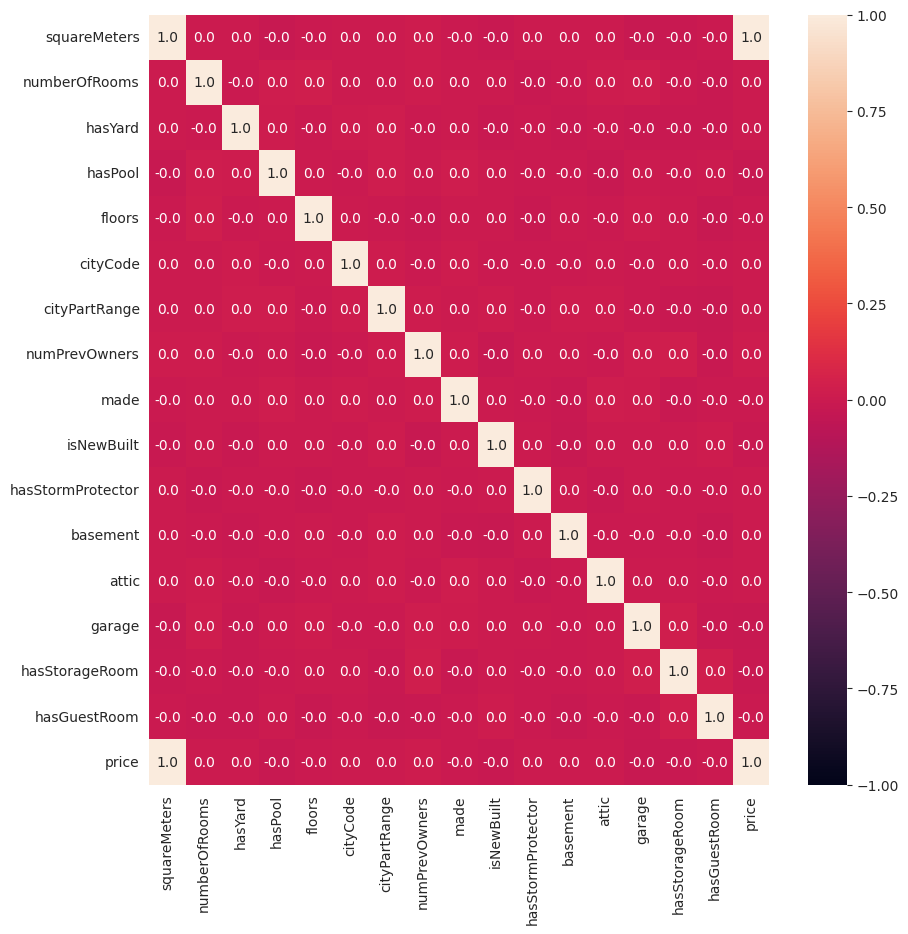

In [9]:
# matrix correlation
matrix = df_plot.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, fmt='.1f', vmin=-1, vmax=1)

In [10]:
spearman_corr = df_plot.corr(method='spearman')
print(spearman_corr['price'])

squareMeters         0.999999
numberOfRooms        0.006316
hasYard              0.004955
hasPool             -0.017299
floors              -0.002080
cityCode             0.001969
cityPartRange        0.007477
numPrevOwners        0.014775
made                -0.006750
isNewBuilt          -0.009556
hasStormProtector    0.004627
basement             0.000695
attic                0.000994
garage              -0.017664
hasStorageRoom      -0.011758
hasGuestRoom        -0.000337
price                1.000000
Name: price, dtype: float64


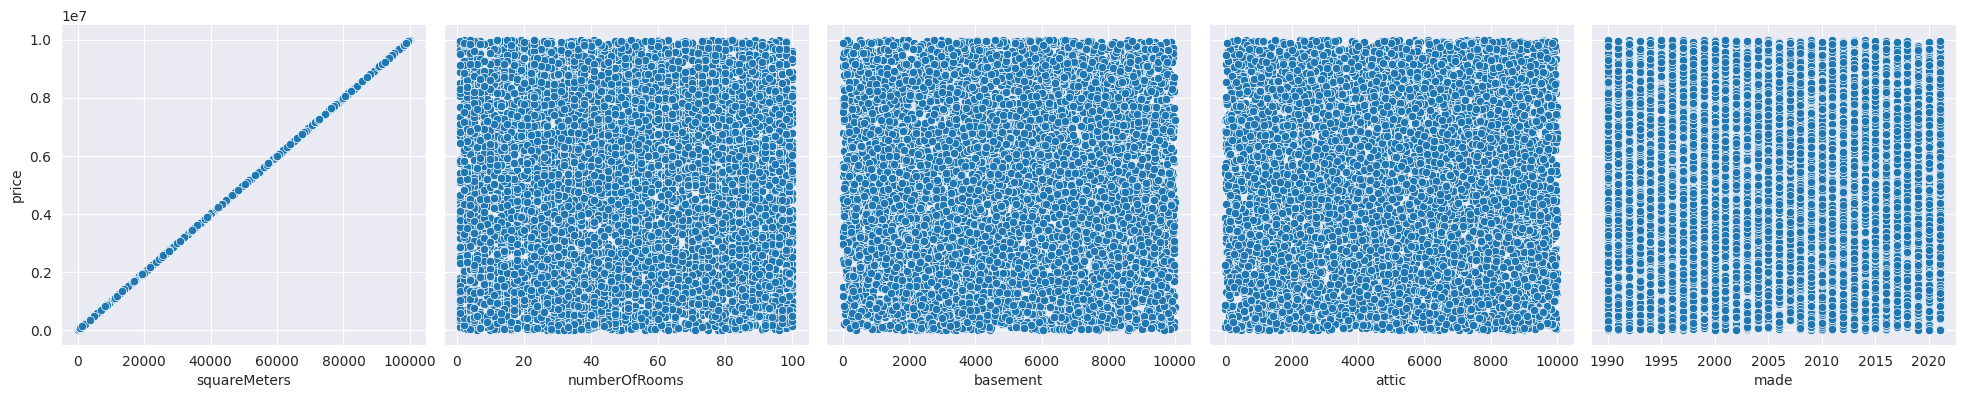

In [11]:
sns.pairplot(
    df_plot,
    x_vars=['squareMeters', 'numberOfRooms', 'basement', 'attic', 'made'],
    y_vars='price',
    height=4,
    aspect=1
)

<h2 style="color:#f0e912"><br>MODEL TRAINING</h2>


<h3 style="color:#0c99d1">LINEAR REGRESSION</h3>

In [46]:
# Model training and prediction
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

In [47]:
# Model evaluation
run_all_metrics(y_pred_linear, y_test, "Linear regression")

📊  Regression model evaluation (Linear regression)
🔹 MAE (Mean Absolute Error) : 1510.03
🔹 RMSE (Root Mean Squared Error)  : 1922.42
🔹 R2  (Coefficient of Determination)  : 1.00


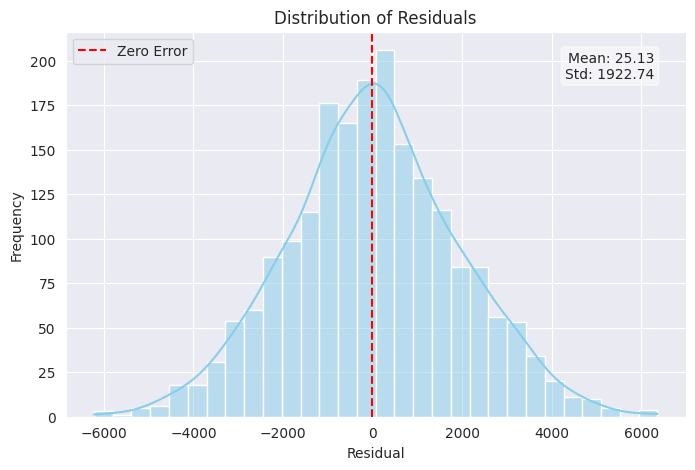

In [48]:
residual_distribution(y_test, y_pred_linear)

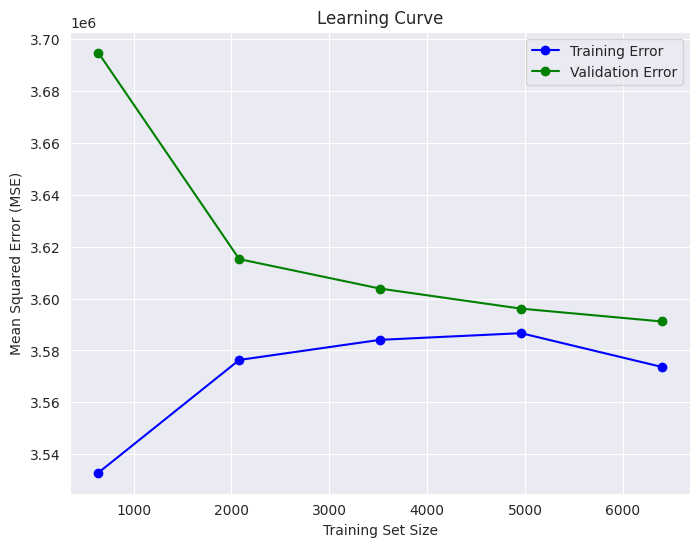

In [49]:
plot_learning_curve(linear_model, X_train, y_train)

<h3 style="color:#0c99d1">DECISION TREE REGRESSOR</h3>


<h4 style="color:#e8b215">SIMPLE SETTING</h4>


In [16]:
# Model definition
decision_tree_model = DecisionTreeRegressor(random_state=42)

In [17]:
# Cross-validation to test the robustness of the model and its ability to generalize to new data
cross_val_score(decision_tree_model, X_train, y_train, cv=10)

array([0.99999617, 0.99999571, 0.99999658, 0.99999572, 0.99999589,
       0.99999633, 0.99999626, 0.99999627, 0.99999585, 0.9999963 ])

In [18]:
# Train regressor model
decision_tree_model.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [19]:
y_pred_decision_tree = decision_tree_model.predict(X_test)

In [20]:
run_all_metrics(y_pred_decision_tree, y_test, "Decision tree regression")

📊  Regression model evaluation (Decision tree regression)
🔹 MAE (Mean Absolute Error) : 4494.98
🔹 RMSE (Root Mean Squared Error)  : 5704.07
🔹 R2  (Coefficient of Determination)  : 1.00


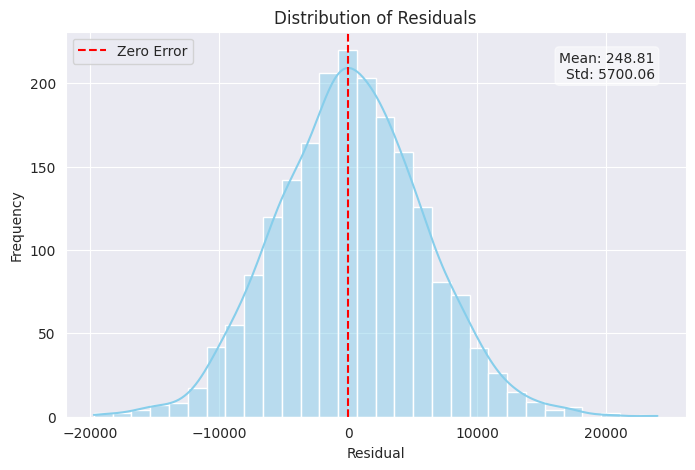

In [21]:
residual_distribution(y_test, y_pred_decision_tree)

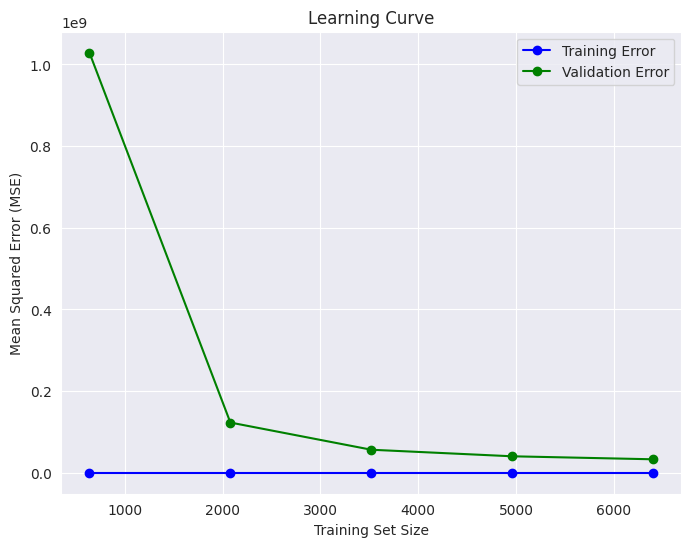

In [22]:
plot_learning_curve(decision_tree_model, X_train, y_train)

<h4 style="color:#e8b215">GRID SEARCH</h4>


In [23]:
# Dictionary of parameters to test
param_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 8, 10, 12, 17,  20],
    'min_samples_split': [2, 5, 10, 15, 30, 45, 50, 70],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'max_features': [None,  'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

In [24]:
best_score = float('inf')
best_params = None

grid = ParameterGrid(param_grid)

for params in tqdm(grid, desc="Grid Search"):
    model = DecisionTreeRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred)

    if score < best_score:
        best_score = score
        best_params = params

Grid Search: 100%|██████████| 6048/6048 [02:37<00:00, 38.31it/s] 


In [25]:
dt_gridsearch_model = DecisionTreeRegressor(**best_params, random_state=42)
dt_gridsearch_model.fit(X_train, y_train)
y_pred_dt_gridsearch = dt_gridsearch_model.predict(X_test)

In [26]:
run_all_metrics(y_pred_dt_gridsearch, y_test, "Decision tree regression")

📊  Regression model evaluation (Decision tree regression)
🔹 MAE (Mean Absolute Error) : 4040.20
🔹 RMSE (Root Mean Squared Error)  : 5097.64
🔹 R2  (Coefficient of Determination)  : 1.00


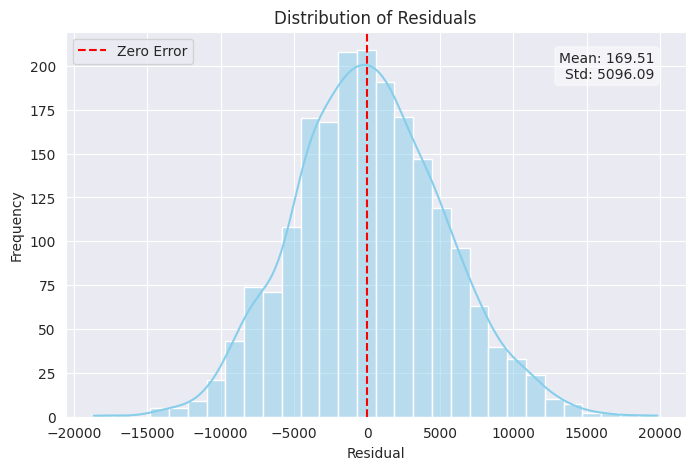

In [27]:
residual_distribution(y_test, y_pred_dt_gridsearch)

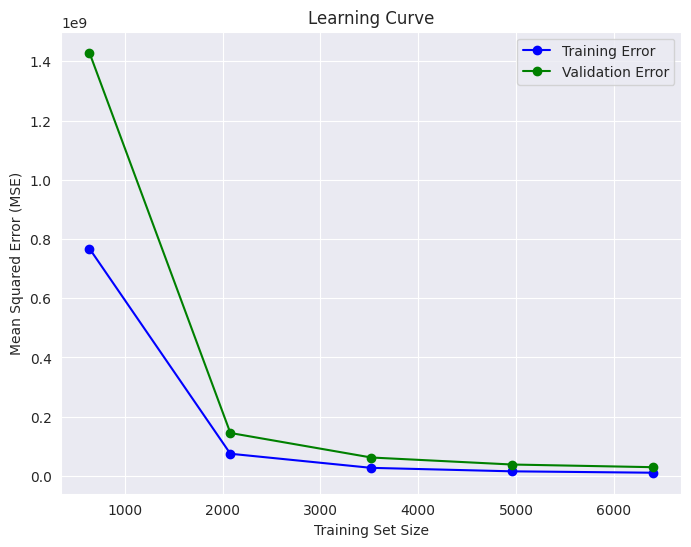

In [28]:
plot_learning_curve(dt_gridsearch_model, X_train, y_train)

<h3 style="color:#0c99d1">RANDOM FOREST REGRESSOR</h3>


<h4 style="color:#e8b215">BAYESIAN OPTIMISATION (OPTUNA)</h4>


In [29]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'random_state': 42
    }

    model = RandomForestRegressor(**params, n_jobs=-1)
    # CV negative score because we minimize MSE
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return -np.mean(score)

In [30]:
warnings.filterwarnings("ignore", message="pkg_resources is deprecated.*")
warnings.filterwarnings("ignore", category=UserWarning)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 66. Best value: 1.83034e+07: 100%|██████████| 100/100 [13:23<00:00,  8.03s/it]


In [31]:
best_params = study.best_params
random_forest_model = RandomForestRegressor(**best_params, random_state=42)
random_forest_model.fit(X_train, y_train)

y_pred_random_forest = random_forest_model.predict(X_test)

In [32]:
run_all_metrics(y_pred_random_forest, y_test, "Decision tree regression")

📊  Regression model evaluation (Decision tree regression)
🔹 MAE (Mean Absolute Error) : 3344.94
🔹 RMSE (Root Mean Squared Error)  : 4356.93
🔹 R2  (Coefficient of Determination)  : 1.00


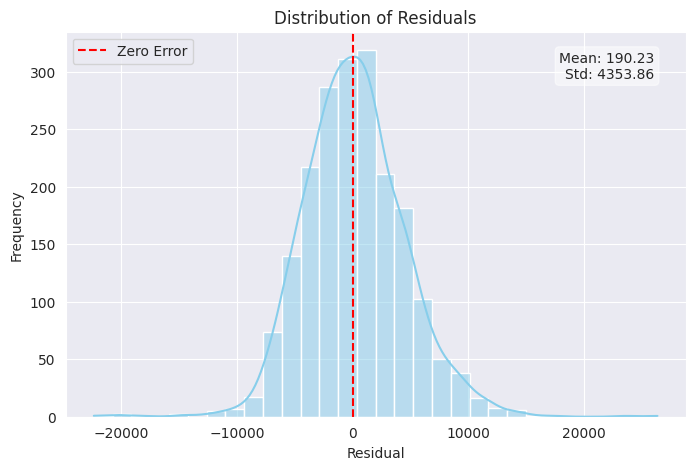

In [33]:
residual_distribution(y_test, y_pred_random_forest)

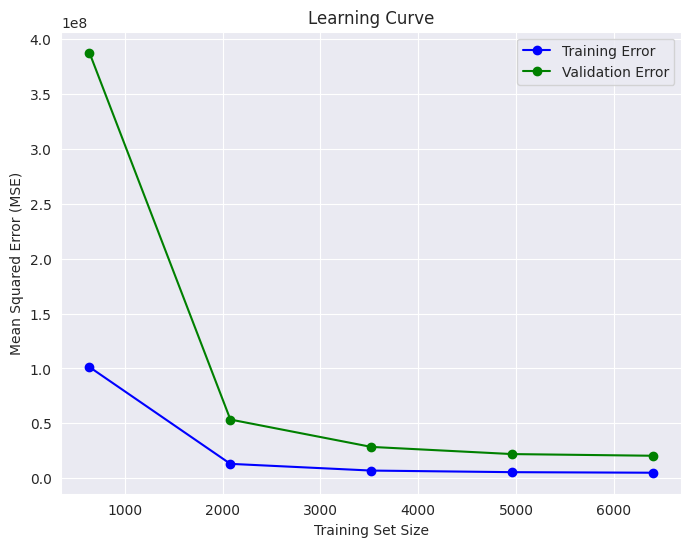

In [34]:
plot_learning_curve(random_forest_model, X_train, y_train)

<h3 style="color:#0c99d1">XGBOOST</h3>


In [35]:
from sklearn.model_selection import KFold
# Hide log
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    # Suggest hyperparameters for XGBoost
    param = {
        "max_depth": trial.suggest_int("max_depth", 4, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.04, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 12),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.45),
        "subsample": trial.suggest_float("subsample", 0.5, 0.6),
        "reg_alpha": trial.suggest_float("reg_alpha", 2, 6, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 60, 100, log=True)
    }

    # Create the model with suggested hyperparameters
    model = xgb.XGBRegressor(**param, random_state=42, n_jobs=-1)

    # Cross-validation with 3 splits
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Compute negative mean squared error scores
    mse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_mean_squared_error")

    # Return positive mean MSE (to be minimized)
    return -mse_scores.mean()

In [36]:
# Create the Optuna study to minimize the objective
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 72. Best value: 2.35916e+09: 100%|██████████| 100/100 [14:10<00:00,  8.51s/it]


In [37]:
best_params = study.best_params
xgboost_optuna_model = xgb.XGBRegressor(**best_params, random_state=42)
xgboost_optuna_model.fit(X_train, y_train)

y_pred_xgboost = xgboost_optuna_model.predict(X_test)

In [38]:
run_all_metrics(y_pred_xgboost, y_test, "XGboost regression")

📊  Regression model evaluation (XGboost regression)
🔹 MAE (Mean Absolute Error) : 35212.45
🔹 RMSE (Root Mean Squared Error)  : 44319.10
🔹 R2  (Coefficient of Determination)  : 1.00


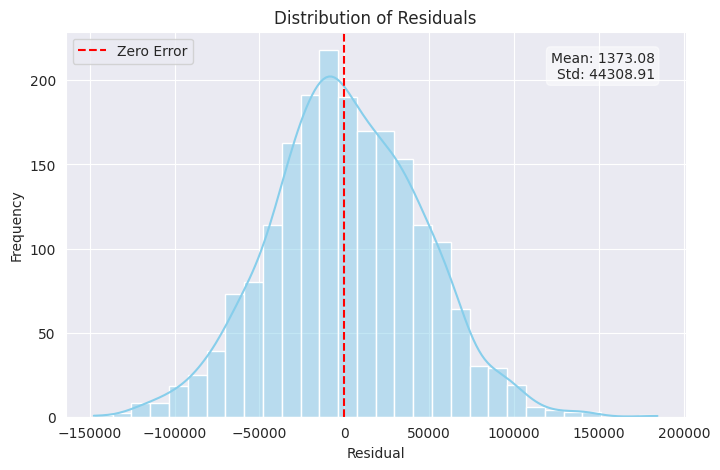

In [39]:
residual_distribution(y_test, y_pred_xgboost)

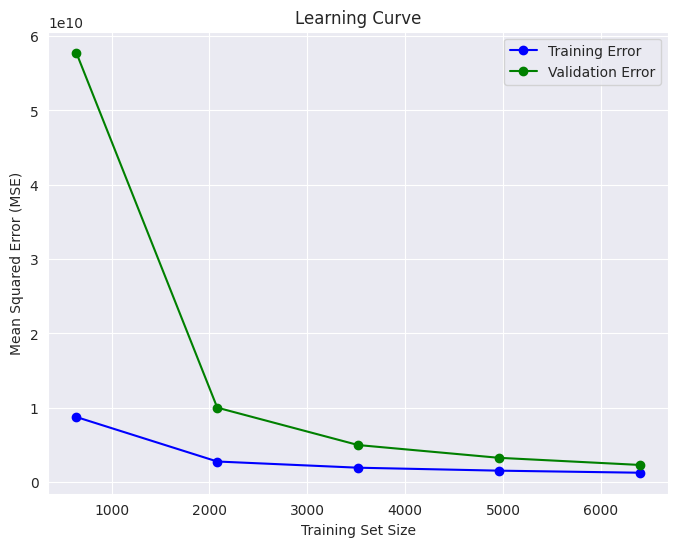

In [40]:
plot_learning_curve(xgboost_optuna_model, X_train, y_train)

<h2 style="color:#f0e912"><br>METRICS VISUALIZATION</h2>


In [50]:
# Retrieve all models MAE, RMSE ANS R2

mae_lin_reg, rmse_lin_reg, r2_lin_reg = evaluation(y_pred_linear, y_test, "mae"), evaluation(y_pred_linear, y_test, "rmse"), evaluation(y_pred_linear, y_test, "r2")

mae_df_dec_tree, rmse_df_dec_tree, r2_df_dec_tree = evaluation(y_pred_decision_tree, y_test, "mae"), evaluation(y_pred_decision_tree, y_test, "rmse"), evaluation(y_pred_decision_tree, y_test, "r2")

mae_gs_dec_tree, rmse_gs_dec_tree, r2_gs_dec_tree = evaluation(y_pred_dt_gridsearch, y_test, "mae"), evaluation(y_pred_dt_gridsearch, y_test, "rmse"), evaluation(y_pred_dt_gridsearch, y_test, "r2")

mae_rforest, rmse_rforest, r2_rforest = evaluation(y_pred_random_forest, y_test, "mae"), evaluation(y_pred_random_forest, y_test, "rmse"), evaluation(y_pred_random_forest, y_test, "r2")

mae_xgboost, rmse_xgboost, r2_xgboost = evaluation(y_pred_xgboost, y_test, "mae"), evaluation(y_pred_xgboost, y_test, "rmse"), evaluation(y_pred_xgboost, y_test, "r2")


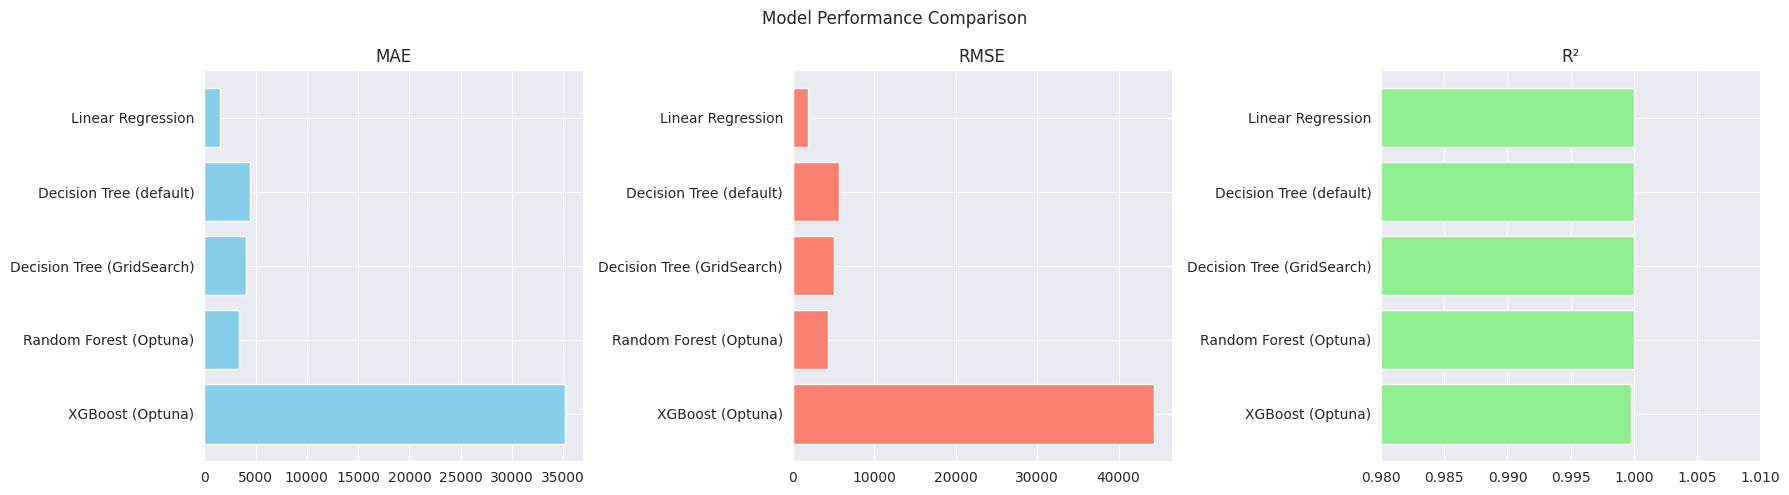

In [59]:
import matplotlib.pyplot as plt

models_names = [
    "Linear Regression",
    "Decision Tree (default)",
    "Decision Tree (GridSearch)",
    "Random Forest (Optuna)",
    "XGBoost (Optuna)"
]

mae_list = [mae_lin_reg, mae_df_dec_tree, mae_gs_dec_tree, mae_rforest, mae_xgboost]
rmse_list = [rmse_lin_reg, rmse_df_dec_tree, rmse_gs_dec_tree, rmse_rforest, rmse_xgboost]
r2_list = [r2_lin_reg, r2_df_dec_tree, r2_gs_dec_tree, r2_rforest, r2_xgboost]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle("Model Performance Comparison")

# MAE
axs[0].barh(models_names, mae_list, color='skyblue')
axs[0].set_title("MAE")
axs[0].invert_yaxis()

# RMSE
axs[1].barh(models_names, rmse_list, color='salmon')
axs[1].set_title("RMSE")
axs[1].invert_yaxis()

# R²
axs[2].barh(models_names, r2_list, color='lightgreen')
axs[2].set_title("R²")
axs[2].invert_yaxis()
axs[2].set_xlim(0.98, 1.01)

plt.tight_layout()
plt.savefig("../outputs/metrics_comparison.png", bbox_inches="tight")
plt.show()


<h2 style="color:#f0e912"><br>GO FURTHER</h2>


#### This section aims to save the trained models along with their evaluation metrics
#### (MAE, RMSE, R²) for use in an interactive Streamlit web application.
#### The app will allow users to dynamically load results, visually compare model performance,
#### and explore predictions through an interactive interface.

In [61]:
from src.save import save_model_metrics, save_trained_models
save_model_metrics(models_names, mae_list, rmse_list, r2_list)
save_trained_models([linear_model, decision_tree_model, dt_gridsearch_model, random_forest_model, xgboost_optuna_model], models_names)

✅ Metrics saved to: ../outputs/metrics_outputs/model_metrics.csv
✅ Model 'Linear Regression' saved to: ../outputs/models/Linear Regression.joblib
✅ Model 'Decision Tree (default)' saved to: ../outputs/models/Decision Tree (default).joblib
✅ Model 'Decision Tree (GridSearch)' saved to: ../outputs/models/Decision Tree (GridSearch).joblib
✅ Model 'Random Forest (Optuna)' saved to: ../outputs/models/Random Forest (Optuna).joblib
✅ Model 'XGBoost (Optuna)' saved to: ../outputs/models/XGBoost (Optuna).joblib
